In [97]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline# This Python 3 environment comes with many helpful analytics libraries installed


UsageError: unrecognized arguments: This Python 3 environment comes with many helpful analytics libraries installed


In [98]:
df = pd.read_csv('/kaggle/input/germanyretaisales/GermanRetaiSales.csv')
df.head()

,Unnamed: 0,date,code,kind_of_trade,turnover
0,0,1/1/2009,WZ08-47781,Activities of opticians,76.5
1,1,1/1/2009,WZ08-4719-02,Retail sale of non-food,80.8
2,2,1/1/2009,WZ08-476,Retail sale of cultural and recreation goods,83.4
3,3,1/1/2009,WZ08-47191,Retail sale in non-specialised stores (ex. food),87.5
4,4,1/1/2009,WZ08-4726,Retail sale of tobacco products,88.6


In [99]:
df = df[['date', 'kind_of_trade', 'turnover']]
dfm =df.loc[df.kind_of_trade =='Retail sale of medical and orthopaedic goods']

In [100]:
print(dfm.shape)
dfm.describe()

(173, 3)


,turnover
count,173.000000
mean,101.995376
std,19.753660
min,62.300000
25%,85.200000
50%,101.300000
75%,116.900000
max,156.600000


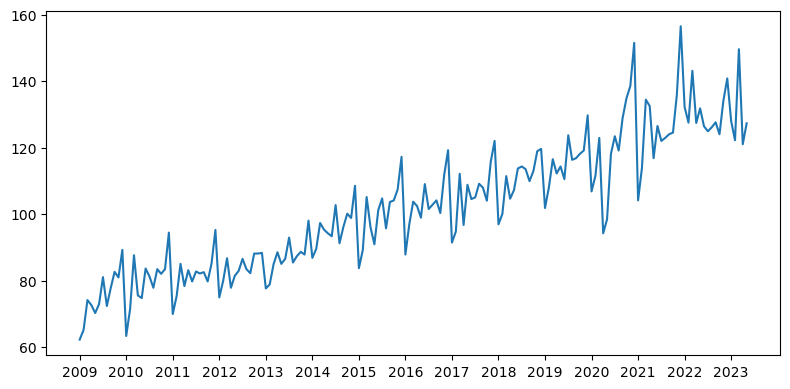

In [101]:
plt.figure(figsize=(8,4))
plt.plot(dfm.date, dfm.turnover)
plt.xticks(np.arange(0, 175, 12), np.arange(2009, 2024, 1))
plt.tight_layout()
#we can see a clear trend and seasonality

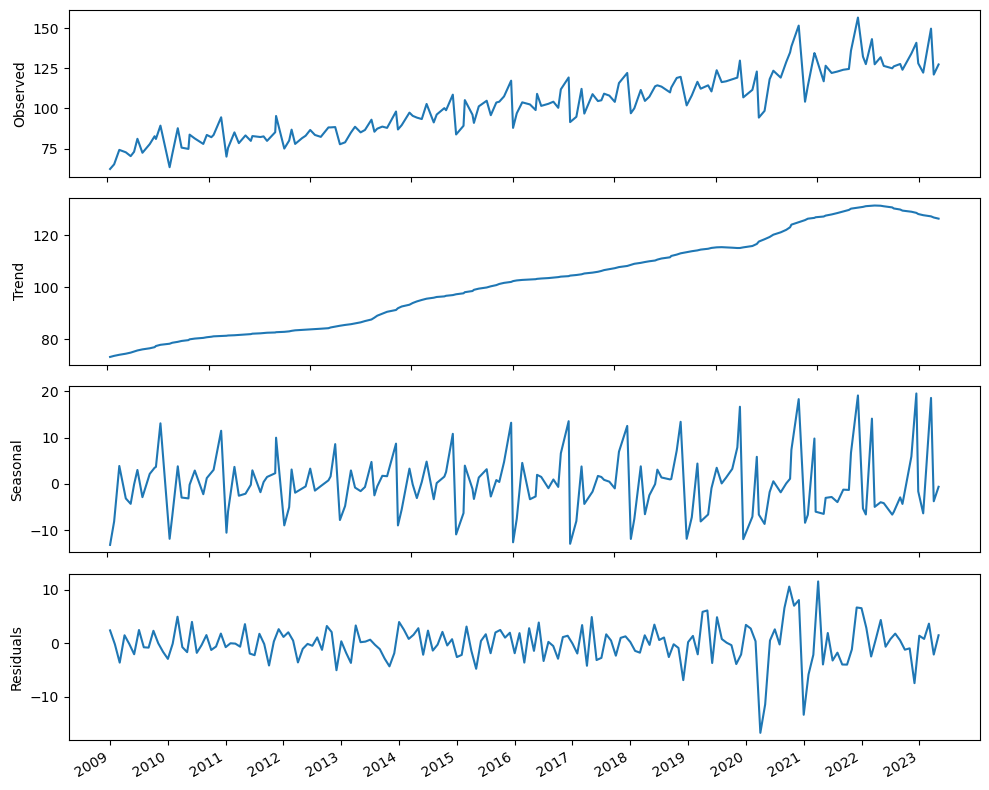

In [102]:
#decomposition
from statsmodels.tsa.seasonal import STL
decomposition = STL(dfm.turnover, period=12).fit()

fig,(ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')
ax2.plot( decomposition.trend)
ax2.set_ylabel('Trend')
ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')
ax4.plot(dfm.date, decomposition.resid)
ax4.set_ylabel('Residuals')
plt.xticks(np.arange(0, 175, 12), np.arange(2009, 2024, 1))
fig.autofmt_xdate()
plt.tight_layout()

#SARIMA model would be a optimal solution

In [103]:
adf_test = adfuller(dfm.turnover)
print(f'ADF: {adf_test[0]:.2f}')
print(f'p_value: {adf_test[1]:.2f}')
# we cannot reject the null hypothesis, and we conclude that the series is not stationary.

ADF: -0.07
p_value: 0.95


In [104]:
# apply a first-order differencing on the data and test for stationarity again
turnover_diff = np.diff(dfm.turnover)
adf_test1 = adfuller(turnover_diff)
print(f'ADF: {adf_test1[0]:.2f}')
print(f'p_value: {adf_test1[1]:.2f}')
# it is stationary now so d=1 & D=0

ADF: -11.77
p_value: 0.00


In [105]:
train = dfm.turnover[:137]
test = dfm.turnover[137:]
len(test)

36

In [106]:
p = range(0,5,1)
d = 1
q = range(0,5,1)
P = range(0,5,1)
Q = range(0,5,1)
D = 0
s = 12
parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [107]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [108]:
optimize_SARIMA(train,parameters_list, d, D, s)


  0%|          | 0/625 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(1, 3, 2, 4)",22.000000
1,"(2, 3, 1, 1)",795.781618
2,"(2, 3, 1, 2)",798.474855
3,"(3, 3, 1, 1)",798.557446
4,"(2, 3, 1, 3)",798.827439
...,...,...
619,"(0, 2, 0, 0)",932.011827
620,"(1, 1, 0, 0)",932.320998
621,"(0, 0, 0, 1)",937.006926
622,"(1, 0, 0, 0)",975.561347


In [109]:
SARIMA_model = SARIMAX(train, order=(1,1,3), seasonal_order=(2,1,4,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)


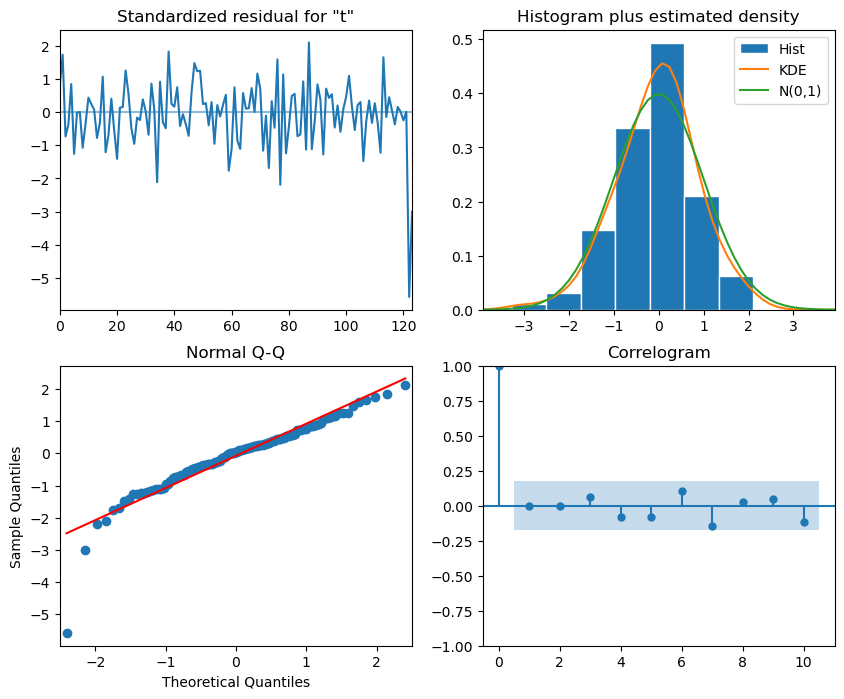

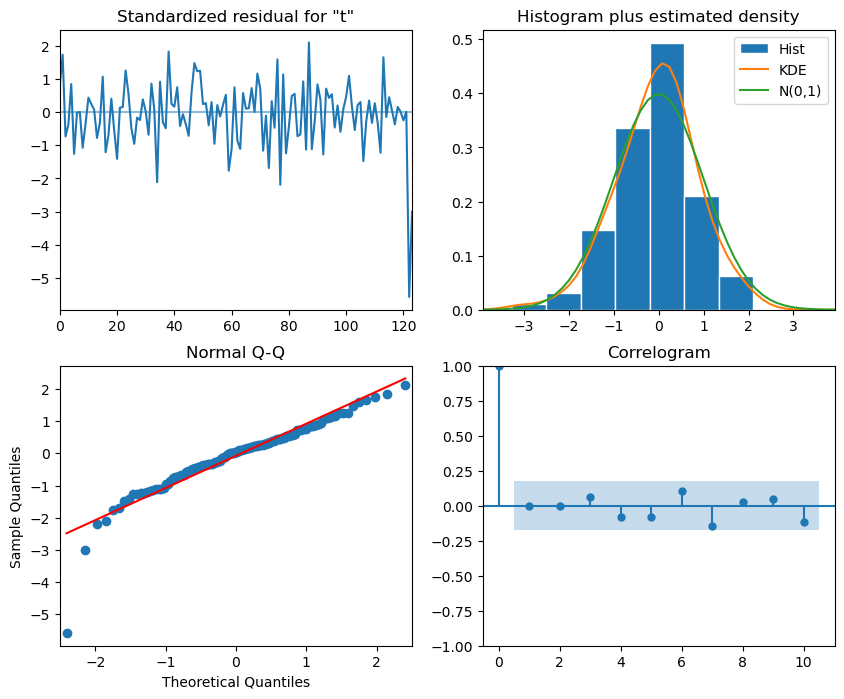

In [110]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))
#In the top-left plot, the residuals have no trend and they closely resemble white noise
#Q-Q plot display a fairly straight line on y=x
#the correlogram plot shows no significant autocorrelation coefficients after lag 0, which is exactly like white noise

In [111]:
residuals = SARIMA_model_fit.resid
acorr_ljungbox(residuals, lags=np.arange(1, 11, 1))
#p_values are greater than .05 so  the residuals are independent and uncorrelated

,lb_stat,lb_pvalue
1,0.701968,0.402123
2,0.706736,0.702319
3,0.793328,0.851062
4,1.295934,0.862065
5,1.420641,0.922042
6,2.209713,0.899436
7,4.157631,0.761453
8,4.866692,0.771725
9,6.151683,0.724646
10,7.505071,0.677056


In [112]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len

    if method == 'last_season':
        pred_last_season = []
        
        for i in range(train_len, total_len, window):
            last_season = df['turnover'][i-window:i].values
            pred_last_season.extend(last_season)
            
        return pred_last_season
    
    elif method == 'SARIMA':
        pred_SARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df['turnover'][:i], order=(2,1,3), seasonal_order=(1,1,3,12), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(oos_pred)
            
        return pred_SARIMA

In [113]:
pred = dfm[137:]

In [114]:
TRAIN_LEN = 137
HORIZON = 36
WINDOW = 12
pred['SARIMA']=rolling_forecast(dfm, TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')


In [115]:
pred['last_season'] = rolling_forecast(dfm, TRAIN_LEN, HORIZON, WINDOW, 'last_season')

In [116]:
pred

,date,kind_of_trade,turnover,SARIMA,last_season
13062,6/1/2020,Retail sale of medical and orthopaedic goods,118.2,113.172592,110.6
13135,7/1/2020,Retail sale of medical and orthopaedic goods,123.5,116.768353,123.8
13280,8/1/2020,Retail sale of medical and orthopaedic goods,119.2,107.870081,116.4
13389,9/1/2020,Retail sale of medical and orthopaedic goods,128.9,115.478014,116.9
13465,10/1/2020,Retail sale of medical and orthopaedic goods,134.9,113.669686,118.2
13491,11/1/2020,Retail sale of medical and orthopaedic goods,138.6,114.576631,119.2
13635,12/1/2020,Retail sale of medical and orthopaedic goods,151.6,128.628943,129.8
13760,1/1/2021,Retail sale of medical and orthopaedic goods,104.2,102.031926,106.9
13815,2/1/2021,Retail sale of medical and orthopaedic goods,114.0,104.634324,111.6
13945,3/1/2021,Retail sale of medical and orthopaedic goods,134.5,121.820207,123.0


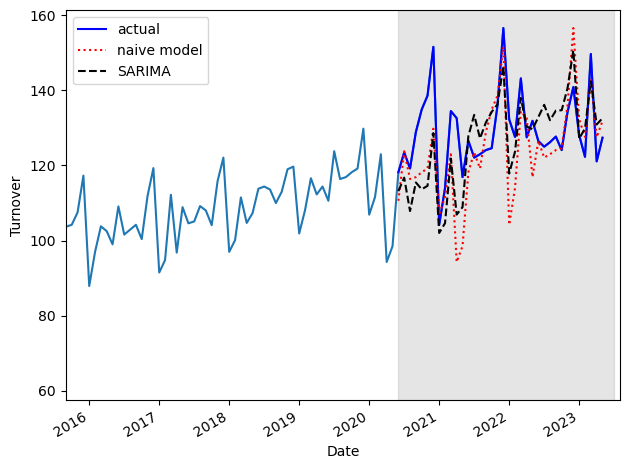

In [117]:
fig, ax = plt.subplots()
ax.plot(dfm.date, dfm.turnover)
ax.plot(dfm.date[137:],pred.turnover, 'b-', label='actual')
ax.plot(dfm.date[137:], pred.last_season, 'r:', label='naive model')
ax.plot(dfm.date[137:],pred.SARIMA, 'k--', label='SARIMA')
ax.set_xlabel('Date')
ax.set_ylabel('Turnover')
ax.axvspan(137, 174, color='#808080', alpha=0.2)
ax.legend(loc=2)
plt.xticks(np.arange(0, 175, 12), np.arange(2009, 2024, 1))
plt.xlim(80, 175)
fig.autofmt_xdate()
plt.tight_layout()

In [118]:
from sklearn.metrics import mean_absolute_percentage_error as mape
mape_SARIMA = mape(pred.turnover, pred.SARIMA)
mape_last = mape(pred.turnover, pred.last_season)

print(f'mape_SARIMA: {mape_SARIMA:.3f}----- mape_last: {mape_last:.3f} \n')

#percentage Error

mape_SARIMA: 0.069----- mape_last: 0.067 

